# Web Scrapping names

In [2]:
# Imports
import requests
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

In [4]:
base_url = 'https://babynames.baby-land.co.il/namelist/?_sft_name_gender='
base_letter_url = "&_sft_name_letter="
first_letter = "אבגדהוזחטיכלמנסעפצקרשת"
gender_url = ['boy', 'girl', 'unisex']
boys = []
girls = []
unisex = []
for gender in gender_url:
    for letter in first_letter:
        print(f'gender: {gender}, letter = {letter}', end='\r')
        url = base_url + gender + base_letter_url + letter
        names_response = requests.get(url)
        names_soup = BeautifulSoup(names_response.text, 'html.parser')
        boys += [name.text for name in names_soup.find_all('a', {'class': 'boys'})]
        girls += [name.text for name in names_soup.find_all('a', {'class': 'girl'})]
        unisex += [name.text for name in names_soup.find_all('a', {'class': 'unisex'})]
C = set(boys)
girls = set(girls)
unisex = set(unisex)

In [38]:
with open('./names/boys.txt', 'w', encoding='utf-8') as f:
    f.write("\n".join(boys))
with open('./names/girls.txt', 'w', encoding='utf-8') as f:
    f.write("\n".join(girls))
with open('./names/unisex.txt', 'w', encoding='utf-8') as f:
    f.write("\n".join(unisex))

In [56]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('names/*.txt'))

import unicodedata
import string
last_letter = 'ךםןףץ'
all_letters = first_letter + last_letter + " .,;'- "

n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    # return [unicodeToAscii(line) for line in lines]
    return lines

for filename in findFiles('names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['names/unisex.txt', 'names/boys.txt', 'names/girls.txt']



In [57]:
print(category_lines['girls'][:5])

['נצחונה', 'לורי', 'אלונה', 'אליזבט', 'ציונה']


In [58]:
import torch
n_letters = len(all_letters)
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0, letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for ii, letter in enumerate(line):
        tensor[ii, 0, letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('א'))
print(letterToTensor('א').shape)

print(lineToTensor('משה').size())

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
torch.Size([1, 34])
torch.Size([3, 1, 34])


In [59]:
import torch.nn as nn
import torch.nn.functional as F

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
    def forward(self, input, hidden):
        combined = torch.concat((input, hidden), dim=1)
        next_h = self.i2h(combined)
        output = F.log_softmax(self.i2o(combined), dim=1)
        return output, next_h
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

        

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [60]:
import torch.nn as nn
import torch.nn.functional as F

class LSTM(nn.Module):
    def __init__(self, in_size, hidden_size, output_size):
        super().__init__()
        self.in_size = in_size
        self.hidden_size = hidden_size
        self.i2f = nn.Linear(in_size + hidden_size, hidden_size)
        self.i2u = nn.Linear(in_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(in_size + hidden_size, hidden_size)
        self.i2c = nn.Linear(in_size + hidden_size, hidden_size)
        self.out_classify = nn.Linear(in_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden, cell):
        combined = torch.concat([input, hidden], dim=1)
        forget = torch.sigmoid(self.i2f(combined))
        update = torch.sigmoid(self.i2u(combined))
        output = torch.sigmoid(self.i2o(combined))
        cell_tild = torch.tanh(self.i2c(combined))
        new_cell = forget * cell + update * cell_tild
        new_hidden = output * torch.tanh(new_cell)
        out_classify = self.softmax(self.out_classify(combined))
        return out_classify, new_hidden, new_cell

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
lstm = LSTM(n_letters, n_hidden, n_categories)

In [61]:
input = letterToTensor("א")
hidden = torch.zeros(1, n_hidden)
cell = torch.zeros(1, n_hidden)

out_classify, new_hidden, new_cell = lstm(input, hidden, cell)

In [62]:
input = lineToTensor('אלברט')
hidden = torch.zeros(1, n_hidden)
cell = torch.zeros(1, n_hidden)

output, next_hidden, next_cell = lstm(input[0], hidden, cell)
print(output)

tensor([[-1.1235, -1.2029, -0.9821]], grad_fn=<LogSoftmaxBackward0>)


In [63]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('girls', 2)


In [64]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = boys / line = ישראל
category = girls / line = עדנה
category = boys / line = אלקנה
category = boys / line = צוק
category = girls / line = אסתר
category = unisex / line = דון
category = unisex / line = פסי
category = unisex / line = לטם
category = girls / line = ליאת
category = girls / line = מלכה


In [73]:
criterion = nn.NLLLoss()
# criterion = nn.CrossEntropyLoss()


In [77]:
learning_rate = 0.003 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = lstm.initHidden()
    cell = lstm.initHidden()
    lstm.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden, cell = lstm(line_tensor[i], hidden, cell)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in lstm.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [79]:
import time
import math

n_hidden = 64
lstm = LSTM(n_letters, n_hidden, n_categories)

n_iters = 300000
print_every = 3000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

3000 1% (0m 3s) 0.6322 גבריאלה / girls ✓
6000 2% (0m 7s) 1.0894 גור / unisex ✗ (boys)
9000 3% (0m 11s) 1.0463 גומא / boys ✗ (unisex)
12000 4% (0m 14s) 0.3206 תיאה / girls ✓
15000 5% (0m 18s) 1.9512 בת חן / unisex ✗ (girls)
18000 6% (0m 22s) 1.1155 ליזט / boys ✗ (girls)
21000 7% (0m 25s) 2.1102 יהודה / girls ✗ (boys)
24000 8% (0m 29s) 1.2169 שבא / boys ✗ (girls)
27000 9% (0m 32s) 0.2872 אווה / girls ✓
30000 10% (0m 36s) 0.8164 עטיל / unisex ✓
33000 11% (0m 40s) 1.2097 מנדל / unisex ✗ (boys)
36000 12% (0m 43s) 1.4132 ליאב / boys ✗ (unisex)
39000 13% (0m 47s) 1.1194 יראל / unisex ✗ (boys)
42000 14% (0m 51s) 1.0426 תום / boys ✗ (unisex)
45000 15% (0m 54s) 0.2529 בתיה / girls ✓
48000 16% (0m 58s) 0.2482 ערבה / girls ✓
51000 17% (1m 2s) 0.7918 מקונן / boys ✓
54000 18% (1m 6s) 0.7733 ענהאל / unisex ✓
57000 19% (1m 9s) 0.8081 עוזי / boys ✓
60000 20% (1m 13s) 0.5886 נאור / unisex ✓
63000 21% (1m 17s) 0.7421 אוריין / unisex ✓
66000 22% (1m 20s) 1.0064 אילי / unisex ✓
69000 23% (1m 24s) 0.5377 אנ

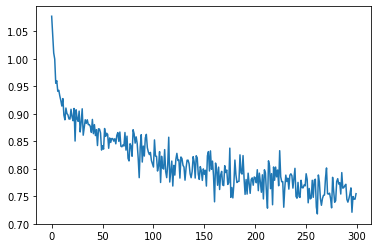

In [80]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

Evaluating the Results
======================

To see how well the network performs on different categories, we will
create a confusion matrix, indicating for every actual language (rows)
which language the network guesses (columns). To calculate the confusion
matrix a bunch of samples are run through the network with
``evaluate()``, which is the same as ``train()`` minus the backprop.




/tmp/ipykernel_1440724/3649271960.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_1440724/3649271960.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


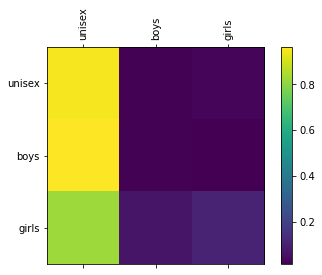

In [81]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()